In [1]:
library(Seurat)
library(countsplit)
library(caret)
library(pracma)
set.seed(1234)

Attaching SeuratObject

Loading required package: ggplot2

Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.1.1”


In [2]:
# args = commandArgs(trailingOnly=TRUE)

# # choose from "hpc", "amy"
# region = as.character(args[1])
# ann.col = as.character(args[2])
# L.version = as.character(args[3]) 
# gene.version = as.character(args[4]) 

# print(paste0("region: ", region))
# print(paste0("ann.col: ", ann.col))
# print(paste0("L.version: ", L.version))
# print(paste0("gene.version: ", gene.version))

In [3]:
region  = "hpc" #hpc, amy, pbmc
ann.col = "seurat_clusters"
L.version = "pcs" # bool pcs
gene.version = "random" # random or hvg

In [4]:
base.dir = file.path("/u/project/halperin/johnsonc/Integrate_CCA/Notebook/PoissonThin")
res.dir  = file.path(base.dir, "res")
fig.dir  = file.path(base.dir, "fig")

In [5]:
if (region != "pbmc"){
    rna.obj = readRDS(paste0("../../Data/RNA/blk6-dba_", region, ".seu.rds"))
}else{
    print("load and preprocess pbmc 3k")
    data(pbmc.counts, package="countsplit")
    rownames(pbmc.counts) <- sapply(rownames(pbmc.counts), function(u) stringr::str_replace_all(u, "_","-"))
    rna.obj = CreateSeuratObject(counts = pbmc.counts, min.cells = 3, min.features = 200)

    rna.obj[["percent.mt"]] <- PercentageFeatureSet(rna.obj, pattern = "^MT-")

    rna.obj <- subset(rna.obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
    rna.obj <- NormalizeData(rna.obj, normalization.method = "LogNormalize", scale.factor = 10000)
    rna.obj <- FindVariableFeatures(rna.obj, selection.method = "vst", nfeatures = 2000)
    rna.obj <- ScaleData(rna.obj, features = VariableFeatures(object = rna.obj))
    rna.obj <- RunPCA(rna.obj, features = VariableFeatures(object = rna.obj))
    rna.obj <- FindNeighbors(rna.obj, dims = 1:10)
    rna.obj <- FindClusters(rna.obj, resolution = 0.5)
    rna.obj <- RunUMAP(rna.obj, dims = 1:10)
}

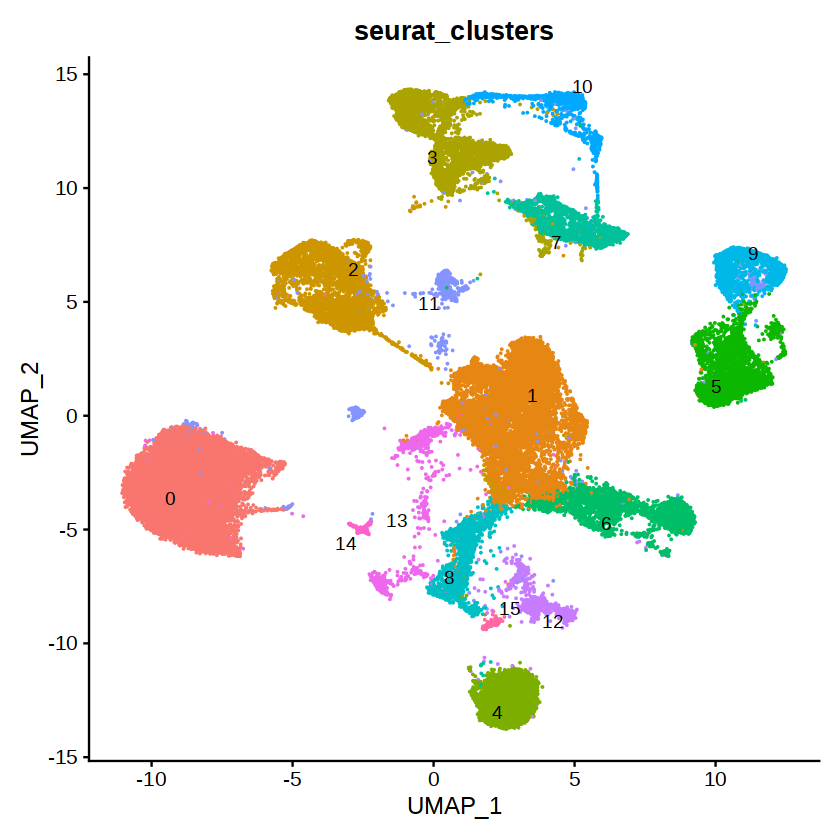

In [6]:
DimPlot(rna.obj, group.by = ann.col, label = TRUE,  repel = TRUE) + NoLegend() 

# latent clusters

In [7]:
if (L.version == "bool"){
    print(paste0("converting celltype annotation to one hot encoded version as L.hat"))
    L.df = rna.obj@meta.data[,"seurat_clusters", drop =F]
    dummy <- dummyVars(" ~ .", data=L.df)
    L.df <- data.frame(predict(dummy, newdata = L.df)) 
    #avoid singular
    print(paste0("Drop the first cluster column that has: ",sum(L.df[,1])/nrow(L.df) * 100, " percent of the cells"))
    L.df = L.df[,2:ncol(L.df),drop = F]
}else{
    print("directly using top 10 PCs as L.hat")
    L.df = rna.obj@reductions$ pca@ cell.embeddings[, 1:10]
}

[1] "directly using top 10 PCs as L.hat"


In [8]:
L.df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
AAACCCAGTCGTGCCA-1,8.0095299,9.164874,-3.9529205,-0.3221960,-2.1701145,-0.36913414,-5.317392542,4.5407865,7.92649681,-3.6727925
AAACCCAGTGTTAGCT-1,-16.0310515,5.329602,4.5877840,-0.9027789,-0.5772683,-0.42747624,0.051126603,-1.6904380,-0.06989926,-1.0384909
AAACCCAGTTCGGCCA-1,-1.4265994,-2.911011,-2.9670546,2.5932209,-1.7717056,1.43115099,-1.895677058,6.7186622,0.18192257,6.3135031
AAACCCAGTTTCGGCG-1,1.3759045,-7.980680,-9.7927211,2.0418446,-0.5835266,-0.44059092,-1.109833448,-5.1423290,3.15633582,-1.2092385
AAACCCATCCGGACTG-1,-1.6480598,-3.600163,-8.4988716,-3.1848571,3.9803754,10.69379686,1.044835164,1.7574499,-1.72673169,-3.3492193
AAACCCATCTGTGCTC-1,12.6092702,20.033275,-7.2077077,1.3827916,-1.8915271,-0.33543685,10.139184593,4.5409302,9.28865340,-2.6544868
AAACGAACAAGGTCTT-1,-8.8096027,1.216531,-1.1054047,-0.1571842,-1.8202209,-0.74077387,-0.999904866,2.7494197,1.10828916,0.3737737
AAACGAACACTACCGG-1,-2.5228230,-3.705129,-4.5822443,1.5119178,0.0384099,-1.87680814,-0.706922338,-4.5708290,4.60634342,1.5592123
AAACGAACAGACCATT-1,-0.1644141,7.824620,-1.2496325,2.3619504,2.2776510,0.78903950,-7.019729309,1.6536905,-1.36612691,-0.5612482
AAACGAACAGCAGTAG-1,5.4494641,-4.659812,11.4499778,1.6556954,5.9072700,-2.66342792,2.501407644,-1.8204150,1.22900968,3.6555114


# Fit GLM NB

In [9]:
p = 2000 
if(gene.version == "hvg"){
    rna.obj <- FindVariableFeatures(rna.obj, selection.method = "vst", nfeatures = p)
    fit.genes = VariableFeatures(rna.obj)
    print(paste0("working on top ", p, " most variable genes"))
}else{
    fit.genes = sample(rownames(rna.obj), p)
    print(paste0("working on random ", p, " genes"))
}

if(region != "pbmc"){
    print("randomely down sampling to 200 genes for mouse dataset (save computational time)")
    p = 200
    fit.genes = sample(fit.genes, p)
}

[1] "working on random 2000 genes"
[1] "randomely down sampling to 200 genes for mouse dataset (save computational time)"


In [10]:
# cells by highly variable genes 
X <- t(as.matrix(rna.obj@ assays$ RNA @ counts [fit.genes, ]))
#library size
sfs = rna.obj@meta.data$nCount_RNA
sfs = sfs/mean(sfs)

In [11]:
f = as.formula(paste0("X ~ ",paste(colnames(L.df), collapse = ' + ')," + offset(log(sfs))"))
print(f)

X ~ PC_1 + PC_2 + PC_3 + PC_4 + PC_5 + PC_6 + PC_7 + PC_8 + PC_9 + 
    PC_10 + offset(log(sfs))


In [12]:
overdisps.file  = file.path(res.dir, paste0("overdisps.",  region, ".", L.version, ".", gene.version, ".rds"))
pred_means.file = file.path(res.dir, paste0("pred_means.", region, ".", L.version, ".", gene.version, ".rds"))

if (!file.exists(overdisps.file) | !file.exists(pred_means.file)){
    overdisps <- data.frame(matrix(NA, nrow=p, ncol=2))
    names(overdisps) <- c("means",  "nb1")
    pred_means <- X[,1:p]

    df = as.data.frame(L.df)
    for (i in 1:p) {
        df$X = X[,i]
        print(i)
        overdisps[i,1] <- mean(X[,i])
        ### Based on this stack overflow thread, I am almost positive that theta is b, not
        ### 1/b. https://stats.stackexchange.com/questions/10419/what-is-theta-in-a-negative-binomial-regression-fitted-with-r
        
        try1 <- try(mod <- MASS::glm.nb(f, data = df))
        if (class(try1) != "try-error") {
            overdisps[i,2] <- mod$theta
            pred_means[,i] <- predict(mod, type="response")
        }
    }
    saveRDS(overdisps,  overdisps.file)
    saveRDS(pred_means, pred_means.file)
}


[1] 1


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 2


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 3


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning me

[1] 4


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 5


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 6


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 7


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 8


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 9


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 10


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 11


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 12


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 13


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 14


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 15


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 16


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 17


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 18


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 19


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$max

[1] 20


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 21


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 22


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 23


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 24


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 25


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 26


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 27


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 28


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 29


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 30


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 31


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, m

[1] 32


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 33


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 34


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 35


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 36


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 37


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 38


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 39


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 40


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 41


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 42


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 43


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 44


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 45


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 46


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 47


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 48


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 49


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 50


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 51


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 52


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 53


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 54


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 55


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 56


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 57


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 58


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 59


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 60


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 61


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 62


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 63


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 64


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algor

[1] 65


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 66


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 67


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 68


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 69


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 70


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 71


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 72


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 73


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 74


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 75


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 76


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 77
Error in glm.fitter(x = X, y = Y, w = w, etastart = eta, offset = offset,  : 
  NA/NaN/Inf in 'x'
[1] 78


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 79


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 80


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 81


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 82


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 83


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 84


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 85


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 86


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 87


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 88


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 89


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 90


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 91


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 92


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 93


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 94


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 95


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 96


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 97


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and onl

[1] 98


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 99


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 100


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 101


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 102


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 103


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 104


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 105


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 106


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 107


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu,

[1] 108


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 109


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 110


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 111


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 112


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning me

[1] 113


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 114


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 115


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 116


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 117


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 118


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 119


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 121


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 122


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 123


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 124


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 125


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 126


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 127


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 128


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 129


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 130


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 131


Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 132


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 133


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 134


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 135


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 136


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 137


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 138


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 139


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 140


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 141


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 142


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 143


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 144


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 145


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 146


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 147


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 148


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 149


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try

[1] 150


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 151


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 152


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control

[1] 153


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 154


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 155


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 156


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 157


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 158


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 159


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 160


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 161


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 162


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 163
Error : no valid set of coefficients has been found: please supply starting values
[1] 164


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 165


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 166


Warning message:
“glm.fit: fitted rates numerically 0 occurred”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 167


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 168


Warning message:
“glm.fit: algorithm did not converge”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 169


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 170


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 171


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 172


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 173


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 174


Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 175


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 176


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 177


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 178


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 179


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 180


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 181


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 182


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 183


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 184


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 185


Warning message:
“step size truncated due to divergence”


Error in glm.fitter(x = X, y = Y, w = w, etastart = eta, offset = offset,  : 
  NA/NaN/Inf in 'x'
[1] 186


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 187


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 188


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 189


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 190


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 191


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 192


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 193


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 194


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 195


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 196


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 197


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 198


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 199


Warning message in if (class(try1) != "try-error") {:
“the condition has length > 1 and only the first element will be used”


[1] 200


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in MASS::glm.nb(f, data = df):
“alternation limit reached”
Warning message in if (class(try1) != "try-er

# Visualize

In [20]:
overdisps  = readRDS(overdisps.file)
pred_means = readRDS(pred_means.file)

In [21]:
overdisps

means,nb1
<dbl>,<dbl>
0.7994628654,1.080822e+01
0.0036359880,3.584199e-02
0.0003512034,1.280368e-04
0.0752814792,4.447959e+00
0.1920875943,5.902129e+00
0.0016940399,4.557533e-02
0.0660882140,1.019933e+00
0.0006610887,1.564204e-02
0.2202251833,3.558994e+00


In [22]:
pred_means

,Dis3l2,Lrrc36,Gm28323,Furin,Eif5,Gm11840,Hist3h2ba,Gm27166,Osbpl11,Tk2,⋯,Treml4,Lhfpl5,Inava,Gm48654,Fzd4,Crybb1,Acp2,Polr2c,1700074H08Rik,Gm15635
AAACCCAGTCGTGCCA-1,0.2308666,0.003514785,3.286958e-07,0.03849500,0.06621310,1.243686e-03,0.01820078,0.0001743565,0.06898520,0.04386971,⋯,4.880242e-05,0.007286839,0.002746048,7.648020e-04,0.001736116,0.0009276979,0.03788212,0.03908320,0.0014889610,8.926703e-05
AAACCCAGTGTTAGCT-1,1.2496708,0.007924938,1.157148e-03,0.06917689,0.24340742,4.668743e-03,0.11274390,0.0003679336,0.25171165,0.08803811,⋯,3.597862e-04,0.010468248,0.006827961,2.680082e-04,0.005813858,0.0045498141,0.11812719,0.13188079,0.0009656579,5.307402e-04
AAACCCAGTTCGGCCA-1,0.5692517,0.001729444,1.888690e-04,0.04924207,0.11471795,6.920110e-04,0.04405347,0.0005132319,0.13998374,0.06335284,⋯,7.443383e-05,0.003735324,0.020491590,2.521562e-04,0.004613337,0.0008318640,0.06753874,0.06798416,0.0014028754,1.180285e-04
AAACCCAGTTTCGGCG-1,0.6784328,0.002682012,6.711742e-09,0.09429257,0.15813045,1.738586e-03,0.05320707,0.0002513475,0.27018506,0.08853862,⋯,1.387638e-04,0.010621217,0.020820757,2.825292e-03,0.004728097,0.0016288315,0.08587627,0.09515638,0.0030941684,9.886224e-06
AAACCCATCCGGACTG-1,0.8606265,0.002082287,9.982925e-05,0.12747325,0.21136384,3.107505e-03,0.09470951,0.0009070972,0.26398021,0.13633658,⋯,1.080576e-04,0.014915558,0.058237508,6.651582e-04,0.007203495,0.0023509745,0.13557075,0.13514090,0.0043196094,9.354640e-05
AAACCCATCTGTGCTC-1,0.6584174,0.014610186,7.221237e-10,0.07761597,0.21659946,3.960946e-03,0.05463366,0.0006914548,0.20168310,0.18256178,⋯,2.711317e-06,0.036349093,0.005143804,1.313512e-03,0.002476190,0.0013598445,0.13135709,0.12225553,0.0086949839,2.842605e-04
AAACGAACAAGGTCTT-1,0.4083315,0.002464833,1.666979e-05,0.03046760,0.08458740,1.471481e-03,0.03614548,0.0002095967,0.09336195,0.03745722,⋯,6.574680e-05,0.003647466,0.007524726,1.801403e-04,0.002560769,0.0010884595,0.04394471,0.04902298,0.0006278668,1.024706e-04
AAACGAACACTACCGG-1,1.6314675,0.008218728,4.049633e-07,0.15960456,0.36255546,3.458025e-03,0.11818993,0.0004245273,0.53613958,0.17443502,⋯,2.434944e-04,0.019350983,0.022039357,2.516758e-03,0.009660725,0.0045766808,0.18564601,0.20125059,0.0040190755,7.029026e-05
AAACGAACAGACCATT-1,0.7259135,0.004368801,1.197279e-02,0.11118467,0.19752651,1.813175e-03,0.06820584,0.0006434670,0.21643537,0.09481943,⋯,5.024327e-04,0.012289295,0.007984395,8.349367e-04,0.008585968,0.0024039362,0.10361802,0.10480658,0.0023191204,5.839348e-04
AAACGAACAGCAGTAG-1,1.5460203,0.004177958,3.326817e-04,0.08623227,0.42407394,1.709443e-04,0.09784970,0.0005939529,0.44405058,0.17617528,⋯,9.985227e-04,0.018427437,0.007161306,7.183670e-03,0.007583439,0.0023985507,0.19711428,0.18113310,0.0035749576,1.021828e-03


In [23]:
over_dis = as.matrix(t(pred_means/repmat(t(as.matrix(overdisps$nb1)), nrow(pred_means),1)))

frac1  = sum(over_dis < 1, na.rm=TRUE)/sum(!is.na(over_dis))
frac10 = sum(over_dis < 10, na.rm=TRUE)/sum(!is.na(over_dis))

### visualization
### Use random indices to avoid crashing the computer. 
randomindices <- sample(1:length(as.numeric(over_dis)), 
                        size=min(5e6, length(as.numeric(over_dis))))

over_dis = as.numeric(t(over_dis))[randomindices]
over_dis = over_dis[!is.na(over_dis)]
over_dis = over_dis[!is.infinite(over_dis)]
over_dis = log10(over_dis)

g = ggplot(data=NULL, aes(x=over_dis, y=..density..))+
    geom_histogram(binwidth = 0.5) + 
    #scale_x_log10() + 
    #original value set to over_dis = 1, since we are in log10, this is set to 0. also plot 1 which is 10 in original space
    geom_vline(xintercept=0, col="red")+
    geom_vline(xintercept=1, col="cyan")+

    theme_classic()+
    xlab("Overdispersion (log10 scale)")+
    ylab("Density")+
    scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) + 
    ggtitle(paste0("Histogram of Estimated Overdispersion Values ", region, "\n", 
                   "frac < 1: ", round(frac1, 3), "    frac < 10: ", round(frac10, 3)))+ 
    theme(plot.title = element_text(hjust = 0.5)) 

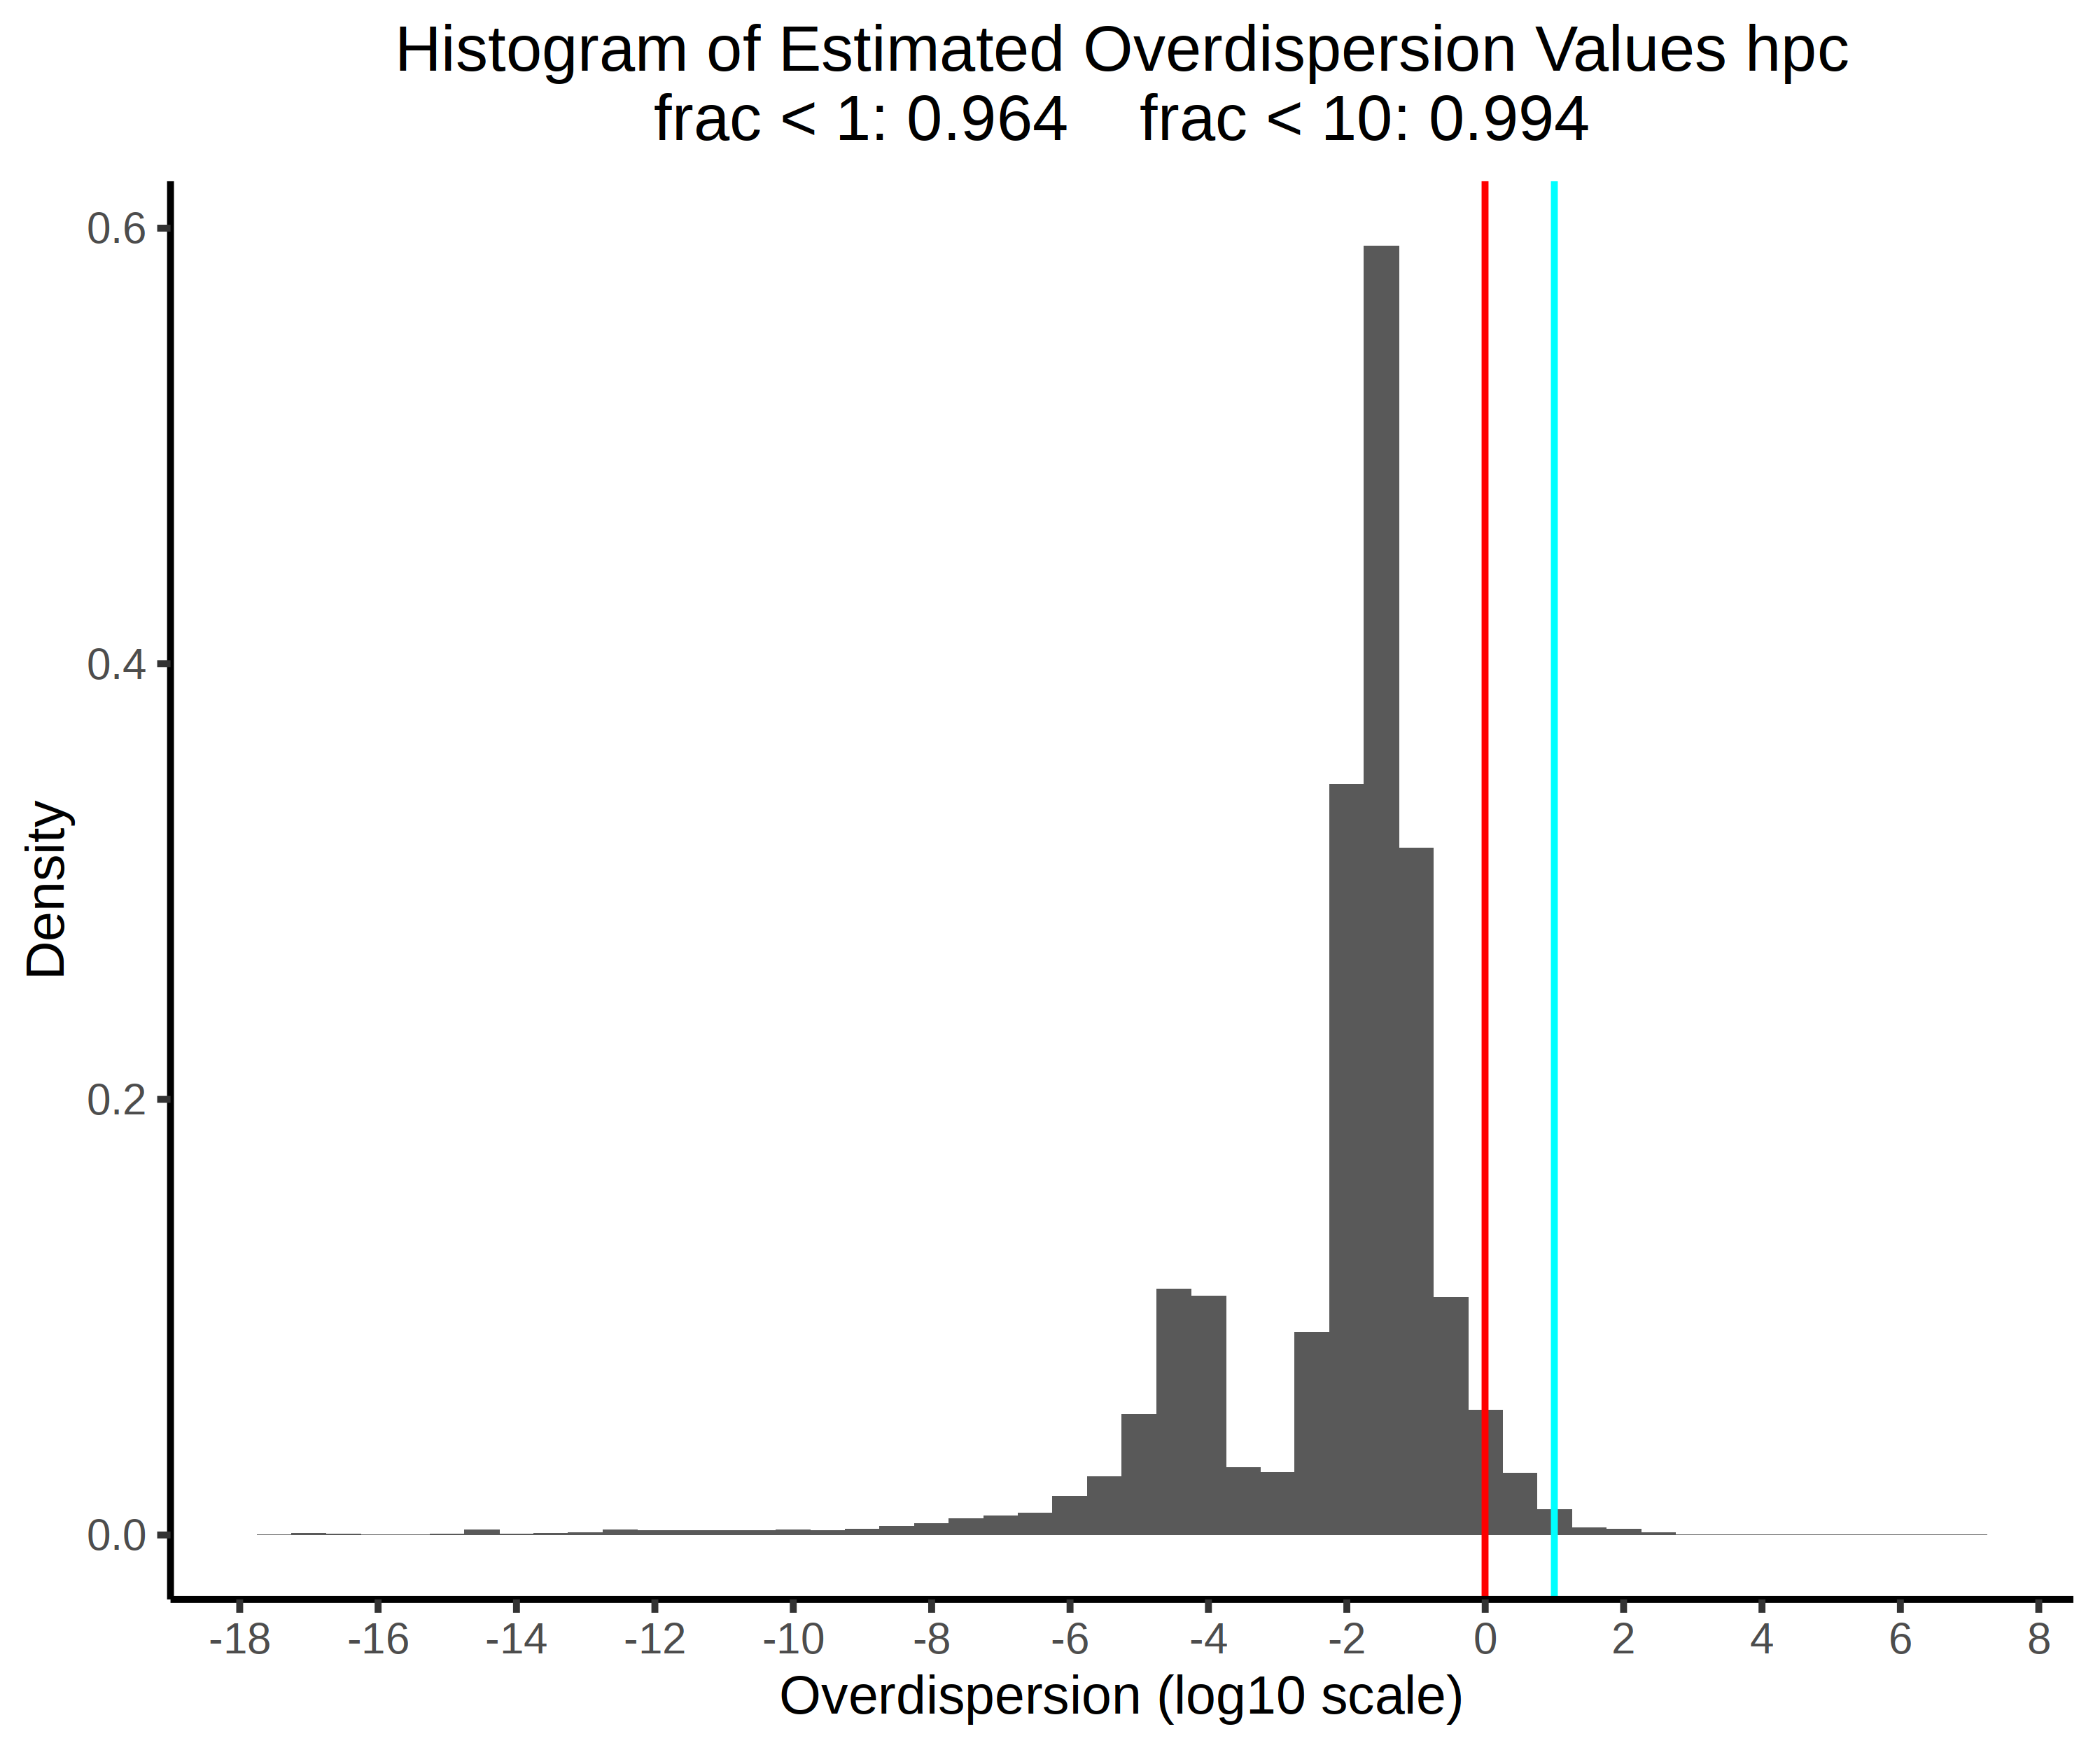

In [24]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 500)
g

In [25]:
ggsave(file.path(fig.dir, paste0("overdisps.", region, ".", L.version, ".", gene.version, ".png")), g, 
       width = 6, height = 6, dpi = 500)